Experiment and Results
==
* **Author**: `Minseong Kim`(tyui592@gmail.com)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from random import shuffle
from tqdm import tqdm
from network import Model
from utils import imload, ten2pil

In [2]:
content = Path('/path/to/content/data')
style = Path('/path/to/style/data')

content_lst = sorted(list(content.glob('*.jpg')))
style_lst = sorted(list(style.glob('*.jpg')))

shuffle(content_lst)
shuffle(style_lst)
content_1k = content_lst[:1000]
style_1k = style_lst[:1000]

device = torch.device('cuda')

## Load model weights

In [3]:
load_path = './model-store/ch_xor/ch_xor.pth'

root_path = Path(load_path).parent

model = Model()
ckpt = torch.load(load_path, map_location='cpu')

model.load_state_dict(ckpt['state_dict'])

model.eval()
model = model.to(device)

# L0-norm

In [4]:
def calc_norm(feature, eps=1e-5):
    vector = feature.flatten(2)
    l2_norm = torch.norm(vector, p=2, dim=2)
    l0_norm = l2_norm / (l2_norm + eps)
    return l2_norm, l0_norm

In [5]:
l0_norm_save_path = root_path / 'l0_norm.npy'
l2_norm_save_path = root_path / 'l2_norm.npy'

l2_norm_lst = []
l0_norm_lst = []
for img_path in tqdm(content_1k + style_1k):
    img = imload(img_path, imsize=512, cropsize=512, cencrop=True)

    # feature extraction
    with torch.inference_mode():
        feature_lst = model.encoder(img.to(device))
    feature = feature_lst[0]

    l2_norm, l0_norm = calc_norm(feature)
    l2_norm_lst.append(l2_norm[0].tolist())
    l0_norm_lst.append(l0_norm[0].tolist())

np.save(l0_norm_save_path, np.asarray(l0_norm_lst))
np.save(l2_norm_save_path, np.asarray(l2_norm_lst))

100%|██████████| 2000/2000 [01:00<00:00, 32.94it/s]


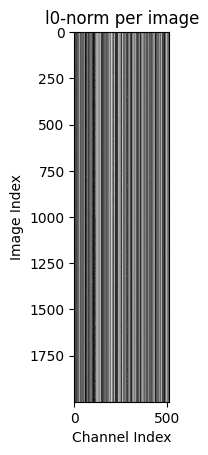

In [6]:
plt.title("l0-norm per image")
plt.imshow(np.asarray(l0_norm_lst), 'gray');
plt.xlabel("Channel Index"); plt.ylabel("Image Index")
plt.savefig(root_path / 'l0_norm.png', bbox_inches='tight')
plt.show()

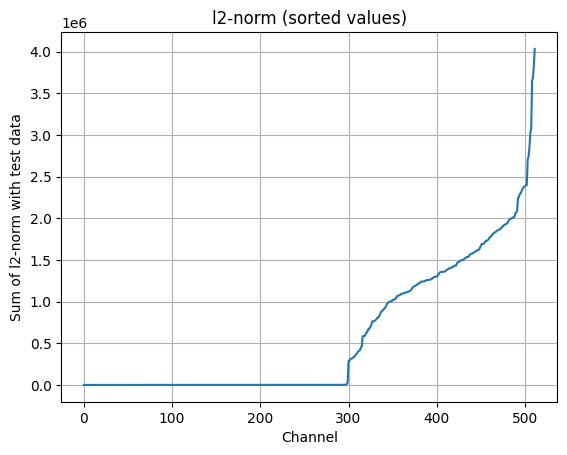

In [7]:
plt.title("l2-norm (sorted values)")
plt.plot(np.sort(np.sum(l2_norm_lst, axis=0)))
plt.grid();
plt.xlabel("Channel"); plt.ylabel("Sum of l2-norm with test data")
plt.savefig(root_path / 'l2_norm_sorted_values.png', bbox_inches='tight')
plt.show()

# Pruning

In [8]:
import copy
from utils import calc_num_params
from prune import prune_style_transfer_network

In [9]:
def pruning_channel(model, channel_indices, nums, content_img, style_img):
    results = []
    for num in nums:
        pruned_model = copy.deepcopy(model.cpu())
        prune_style_transfer_network(pruned_model, channel_indices[:num].tolist())
        print(f"Number of parameters after pruning ({num} channels): {calc_num_params(pruned_model)}")
        with torch.inference_mode():
            output = pruned_model(content=content_img, style=style_img)

        results.append(ten2pil(output))        
    return results

In [10]:
content_img = imload('./imgs/content/lena.jpg', imsize=512, cropsize=512, cencrop=True)
style_img = imload('./imgs/style/mondrian.jpg', imsize=512, cropsize=512, cencrop=True)

In [11]:
l2_norm_arr = np.asarray(l2_norm_lst)
channel_mag = np.sum(l2_norm_arr, axis=0)

In [12]:
sorted_channel_indices = np.argsort(channel_mag)

In [13]:
nums = [0, 100, 200, 300, 400, 470, 490, 500]
results = pruning_channel(model=model,
                          channel_indices=sorted_channel_indices, 
                          nums=nums,
                          content_img=content_img,
                          style_img=style_img)

Number of parameters after pruning (0 channels): 7010947
Number of parameters after pruning (100 channels): 6550047
Number of parameters after pruning (200 channels): 6089147
Number of parameters after pruning (300 channels): 5628247
Number of parameters after pruning (400 channels): 5167347
Number of parameters after pruning (470 channels): 4844717
Number of parameters after pruning (490 channels): 4752537
Number of parameters after pruning (500 channels): 4706447


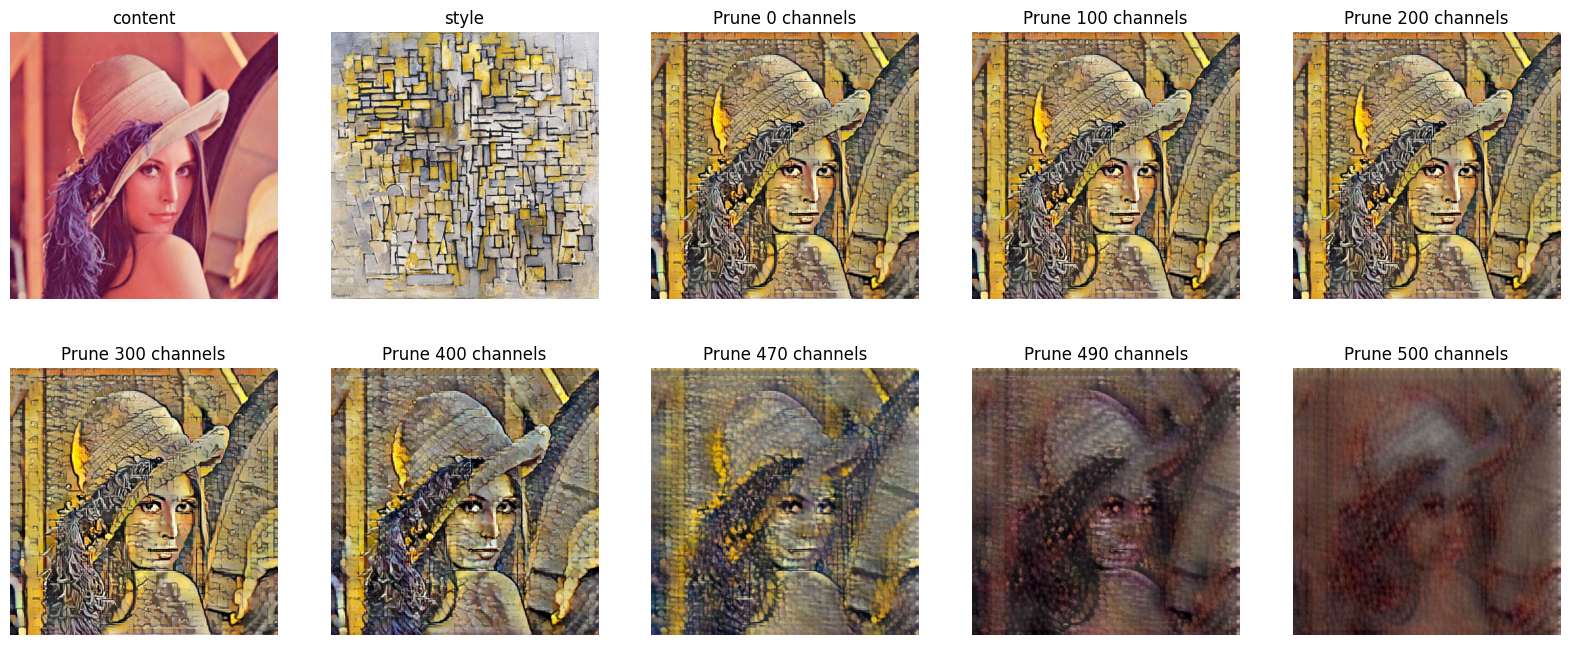

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
labels = ['content', 'style'] + [f'Prune {num} channels' for num in nums]
for index, img in enumerate([ten2pil(content_img), ten2pil(style_img)] + results):
    i, j = index // 5, index % 5
    axes[i][j].set_title(labels[index])
    axes[i][j].imshow(img)
    axes[i][j].axis('off')
plt.savefig(root_path / 'prunings.png', bbox_inches='tight')
plt.show()